In [1]:
#Torsion

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import pymc3 as pm
from scipy.stats import gaussian_kde
import scipy.integrate as integrate

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.5


In [3]:
class AXIS_interval:
    
    def __init__(self, x_iv):
        self.m = x_iv[2]+1
        self.x = np.linspace(x_iv[0],x_iv[1],self.m)
        self.xrev = np.linspace(x_iv[1],x_iv[0],self.m)
        return


class AXIS_global:
    
    def __init__(self, x_iv, x_iv1):
        self.AXI = []
        # Input of xs,xe,n_sample per interval----------
        for i in range(len(x_iv)):
            self.AXI.append(AXIS_interval(x_iv[i]))
        self.iv1 = x_iv1     # index of interval [..., 1]
        
        self.niv = len(self.AXI)    # total no. of intervals
        self.n1 = 0                 # index of x=1
        for i in range(self.iv1+1):
            self.n1 += self.AXI[i].m
        self.n1 -= self.iv1+1

        self.m = 0
        for i in range(self.niv):
            self.m += self.AXI[i].m
        self.m -= self.niv-1
        self.x = np.zeros(self.m)
        k = 0
        for i in range(self.niv):
            for j in range(self.AXI[i].m):
                self.x[k+j] = self.AXI[i].x[j]
            k += self.AXI[i].m-1
        return


In [4]:
# Friedman equations
def FL_equations(x, y, yp, *args):
    Om   = args[1]
    Orad = args[2]
    Ol   = args[3]
    Ok   = args[4]

    err = 0
    a = y[0]
    H = y[1]
    s = y[2]
    if np.isfinite(a) and np.isfinite(H) and np.isfinite(s) and a > 1.e-14:
        a2 = a**2
        a3 = a**3
        H2 = H**2
        s2 = s**2
        yp[0] = a*H
        if args[0] == 'GR':       # General relativity                       
            yp[1] = -2*H2+2*(Om/(a3*4)+Ol)+Ok/a2
            yp[2] = 0
        elif args[0] == 'EC':     # Einstein Cartan   
            V0 = -Om/a-Orad/a2-Ol*a2                    
            yp[1] = -H**2+V0/a2+2*(Om/(a3*4)+Ol)
            yp[2] = -H*s
        else:                   # CCGG, Ol = 0
            Os  = args[6]
            Os2 = Os/2
            Og  = Ol*(3-5*Os)/(1-Os)**2/2
            M   = Om/(a3*4)
            V0  = -Om/a-Orad/a2
            yp[1] = -2*H2+2*M+Ok/a2-(Os-1)*s2
            ks = (H2*s2-M*(3*Om/(a3*4)+Orad*a**(-4))
                  +Os2*s2*(H2+(Os2-1)*s2-Ok/a2)
                  +(Og-M)*(H2+V0/a2-Ok/a2+(Os-1)*s2))
            if ks < 1.e-14: err = 2
            else: yp[2] = -H*s+2*np.sqrt(ks)
    else:
        err = 1
    return yp, err


# 1st order Runge Kutta
def FO_RK4(neq, f, x, y, yp, *args):
    m   = len(x)         
    h   = x[1]-x[0]
    h2  = h/2
    err = 0
    nerr = -1
    msg = ''
 
    for i in range(1, m):
        yh = y[0:neq, i-1]
        k1, err1 = f(x[i-1],    yh,      yp, *args)
        k1 = k1*h
        k2, err2 = f(x[i-1]+h2, yh+k1/2, yp, *args)
        k2 = k2*h
        k3, err3 = f(x[i-1]+h2, yh+k2/2, yp, *args)
        k3 = k3*h
        k4, err4 = f(x[i-1]+h,  yh+k3,   yp, *args)
        k4 = k4*h
        y[0:neq,i] = yh+(k1+2*k2+2*k3+k4)/6

        if err1+err2+err3+err4 != 0:
            msg = ('\n FO_RK4/cause of termination:'
                   +' ({0:d},{1:d},{2:d},{3:d}) at x[{4:d}] ={5:10.3e}'
                  .format(err1, err2, err3, err4, i, x[i]))
            err = 1
            nerr = i
            break
    return err, msg, nerr


def calc_aHs(EV, AX, *args):
    neq = 3     # number of equations
    y0 = np.zeros(neq)
    y0[0] =  1    # a(1)
    y0[1] =  1    # H(1)
    # y0[2] =       s(1)
    if args[0] == 'GR':
        y0[2] = 0
    elif args[0] == 'EC':
        s02 = 1-args[1]-args[2]-args[3]-args[4]
        if s02 > 1.e-14:
            y0[2] = np.sqrt(s02)
        else:
            err = 1
            EV.append('\n EC: no valid parameter set')
    else:
        y0[2] = np.sqrt(2*args[3]/(1-args[6]))
        
    y = np.zeros((neq,AX.m))
    yp = np.zeros(neq)    
    imin = 0
    imax = AX.m-1
    
    k = AX.n1
    y[0:neq,k] = y0
    for i in range(AX.iv1,-1,-1):
        xi = AX.AXI[i].xrev
        yi = np.zeros((neq, AX.AXI[i].m))
        yi[0:neq,0] = y[0:neq,k]
        err, msg, nerr = FO_RK4(neq, FL_equations, xi, yi, yp, *args)
        for j in range(AX.AXI[i].m):
            y[0:neq,k-j] = yi[0:neq,j]
        if err != 0: 
            EV.append(msg)
            imin = k-nerr+2
            break
        k -= AX.AXI[i].m-1
    
    k = AX.n1
    y[0:neq,k] = y0
    for i in range(AX.iv1+1,AX.niv):
        xi = AX.AXI[i].x
        yi = np.zeros((neq, AX.AXI[i].m))
        yi[0:neq,0] = y[0:neq,k]
        err, msg, nerr = FO_RK4(neq, FL_equations, xi, yi, yp, *args)
        for j in range(AX.AXI[i].m):
            y[0:neq,k+j] = yi[0:neq,j]
        if err != 0:
            EV.append(msg)
            imax = k+nerr-1
            break
        k += AX.AXI[i].m-1
    return imin, imax, AX.x, y


def calc_mu(EV, *args):
    Om   = args[1]
    Orad = args[2]
    Ol   = args[3]
    Ok   = args[4]
    H0   = args[5]*2.13312e-42
    H0_1 = 1/H0
    err  = 0

    # t-axis
    t_iv = []
    t_iv.append([0, 1,  200])
    t_iv.append([1, 10, 200])
    t_iv1 = 0
    AX = AXIS_global(t_iv, t_iv1)
    
    # Solve Friedman equations
    imin, imax, x, y = calc_aHs(EV, AX, *args)
    if err != 0: return err, 0, 0, 0, 0, 0, 0
    a = y[0]
    H = y[1]
    
    # z-axis
    nz   = 200
    zmin = 0
    zmax = 1.7
    z    = np.linspace(zmin, zmax, nz)

    # Integrand of luminosity distance    
    di   = np.zeros(nz)
    for i in range(0,nz):
        az = 1/(z[i]+1)
        az2 = az**2
        if args[0] == 'GR': di[i] = az/(H0*np.sqrt(Ok+Om/az+Orad/az2+Ol*az2))
        else:
            j = 0
            for j in range(imin+1,imax):
                if a[j] > az:
                    da = (az-a[j-1])/(a[j]-a[j-1])
                    break
            Hz = H[j]+da*(H[j]-H[j-1])
            di[i] = H0_1/Hz
            
    # mu
    mu   = np.zeros(nz)
    dz2 = (z[1]-z[0])/2
    for i in range(1,nz):
        mu[i] = mu[i-1]+dz2*(di[i]+di[i-1])
    for i in range(1,nz):
        mu[i] = 5*np.log10((1+z[i])*mu[i]/1.5637382e38)+25
    return z[1:nz], mu[1:nz]


In [5]:
def plotposts(samples,**kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [slo, inter]

    fig = corner.corner(samples, labels=[r'$a$', r'$b$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
        


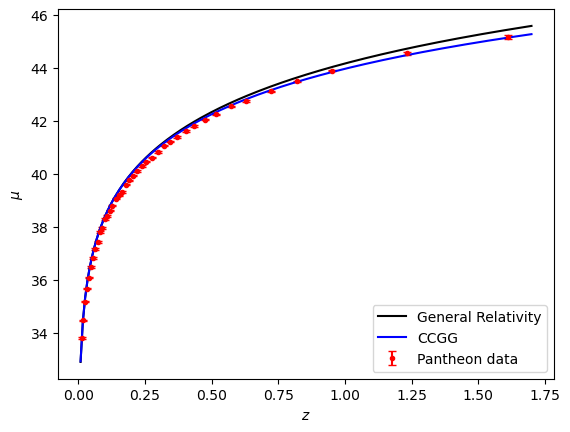

In [6]:
# model: GR =general relativity, EC = Einstein Cartan, CG = CCGG
# examples:
#               Om,    Orad,    Ol,     Ok  ,  h      Os
#args = ('GR', 0.315, 5.44e-5, 0.685,  0.000, 0.674, 0.850)
#args = ('EC', 0.300, 5.44e-5, 0.685,  0.000, 0.674, 0.850)
#args = ('CG', 0.315, 5.44e-5, 0.685,  0.000, 0.674, 0.850)

# read redshift data
rs_data = pd.read_csv('lcparam_DS17f.txt',sep=' ')              # reduced data set
#rs_data = pd.read_csv('lcparam_DS17f_ext.txt',sep=' ')          # reduced data set+
#rs_data = pd.read_csv('lcparam_full_long_zhel.txt',sep=' ')    # full data set
rs = rs_data['zcmb']            # redshift
appmag = rs_data['mb']
appmag_unc = rs_data['dmb']
absmag = -19.25                  # add. shift for abs. magnitude
dm = appmag - absmag            # distance modulus mu = m - M
dm.shape
dm_unc = appmag_unc             # errorbar

# calculate distance module
#starttime = time.time()  
EV = []
args = ('GR', 0.315, 5.44e-5, 0.685,  0.000, 0.674, 0.850)
z_GR, mu_GR = calc_mu(EV, *args)
args = ('CG', 0.315, 5.44e-5, 0.685,  0.000, 0.674, 0.850)
z_CG, mu_CG = calc_mu(EV, *args)
#elapsedtime = time.time()-starttime
#print('\n elapsed time [sec] = ', elapsedtime)

# plot
plt.figure()
plt.errorbar(rs, dm, yerr=dm_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(z_GR, mu_GR, 'k', label='General Relativity')
plt.plot(z_CG, mu_CG, 'b', label='CCGG')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.show()
